In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.model_selection import train_test_split

In [2]:
import os
print(os.getcwd())


C:\Python_Workspace\Untitled Folder


In [4]:
# 시드 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 이미지 경로 설정
path =path = r"C:\Python_Workspace\Untitled Folder\Image"

image_paths = sorted([
    os.path.join(path, fname)
    for fname in os.listdir(path)
    if (fname.lower().endswith('.jpg') or fname.lower().endswith('.png'))
    and ('o' in fname.lower() or 'x' in fname.lower())
])

# 이미지 전처리 함수
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(image, [64, 64])
    # 대비 향상
    image = tf.image.adjust_contrast(image, 2)
    # 정규화
    image = tf.cast(image, tf.float32) / 255.0
    return image


# 이미지 로딩
path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# 라벨 생성 (o → 0, x → 1)
labels = [0 if 'o' in os.path.basename(p).lower() else 1 for p in image_paths]

# numpy 변환 및 셔플
images = np.array(list(image_ds.as_numpy_iterator()))
labels = np.array(labels)
idx = np.random.permutation(len(images))
images, labels = images[idx], labels[idx]

# 데이터 분할
total = len(images)
train_end = int(0.8 * total)
val_end = int(0.9 * total)

train_images, val_images, test_images = images[:train_end], images[train_end:val_end], images[val_end:]
train_labels, val_labels, test_labels = labels[:train_end], labels[train_end:val_end], labels[val_end:]

# npz 저장
np.savez_compressed('datasets_split.npz',
                    train_images=train_images, train_labels=train_labels,
                    val_images=val_images, val_labels=val_labels,
                    test_images=test_images, test_labels=test_labels)

# npz 로드
data = np.load('datasets_split.npz')
train_images = data['train_images']
train_labels = data['train_labels']
val_images = data['val_images']
val_labels = data['val_labels']
test_images = data['test_images']
test_labels = data['test_labels']

# Dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(1000, seed=SEED).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

# 클래스 이름
class_names = ['o', 'x']

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),      # ±10% 회전
    tf.keras.layers.RandomZoom(0.1),          # ±10% 줌
    tf.keras.layers.RandomTranslation(0.1, 0.1) # ±10% 평행이동
])


# CNN 모델 구성 (add 방식 사용)
model = Sequential([
    data_augmentation,
    Conv2D(64, (3,3), activation='relu', input_shape=(64, 64, 1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # 이진 분류
])


# 컴파일
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# 모델 학습
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

# 평가
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print(f"\n Test accuracy: {test_acc:.4f}")

# 전체 예측
y_pred_probs = model.predict(test_images)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_labels

# 라벨 문자열로 변환
true_labels_str = [class_names[i] for i in y_true]
pred_labels_str = [class_names[i] for i in y_pred]




Epoch 1/50


C:\Users\82102\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.7493 - loss: 1.3471 - val_accuracy: 0.8333 - val_loss: 0.5776
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.8225 - loss: 1.0284 - val_accuracy: 0.7500 - val_loss: 0.5308
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.8407 - loss: 0.6308 - val_accuracy: 0.8542 - val_loss: 0.5117
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.8642 - loss: 0.4435 - val_accuracy: 0.5208 - val_loss: 0.7034
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.8695 - loss: 0.4465 - val_accuracy: 0.6250 - val_loss: 0.6839
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.8982 - loss: 0.3857 - val_accuracy: 0.6458 - val_loss: 0.5693
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.9164 - loss: 0.1971 - val_accuracy: 0.7917 - val_loss: 0.4429
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9086 - loss: 0.2229 - val_accuracy: 0.7083 - val_

In [5]:
K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(images, labels)):
    print(f"\n Fold {fold+1}/{K}")

    X_train, X_val = images[train_idx], images[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    # Dataset 구성
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000, seed=SEED).batch(32)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)


    # 학습
    history = model.fit(train_dataset, validation_data=val_dataset,
                        epochs=30,
                        verbose=1)

    # 평가
    val_preds = model.predict(X_val)
    val_preds_cls = (val_preds > 0.5).astype(int).flatten()
    acc = accuracy_score(y_val, val_preds_cls)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")


 Fold 1/5
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.9608 - loss: 0.1235 - val_accuracy: 0.9375 - val_loss: 0.1280
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.9713 - loss: 0.0812 - val_accuracy: 0.9896 - val_loss: 0.0383
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9582 - loss: 0.0825 - val_accuracy: 0.9583 - val_loss: 0.0530
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.9556 - loss: 0.1030 - val_accuracy: 0.8958 - val_loss: 0.5892
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.9661 - loss: 0.0810 - val_accuracy: 0.9271 - val_loss: 0.4193
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.9687 - loss: 0.1119 - val_accuracy: 0.9271 - val_loss: 0.4044
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.9713 - loss: 0.0800 - val_accuracy: 0.8958 - val_loss: 1.5458
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.9713 - loss: 0.0859 - val_a

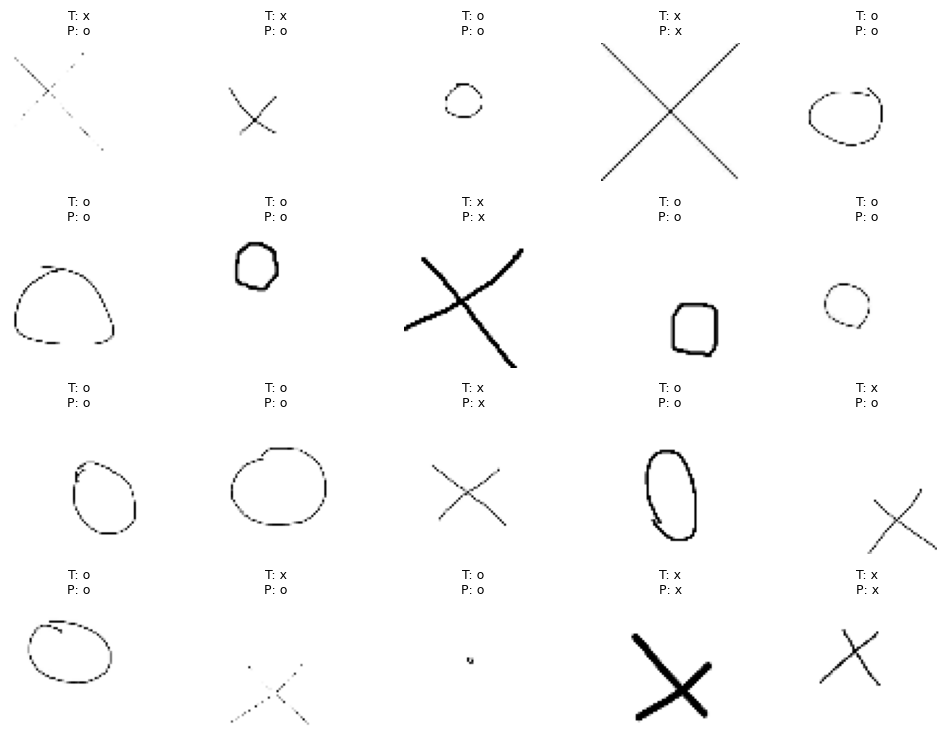

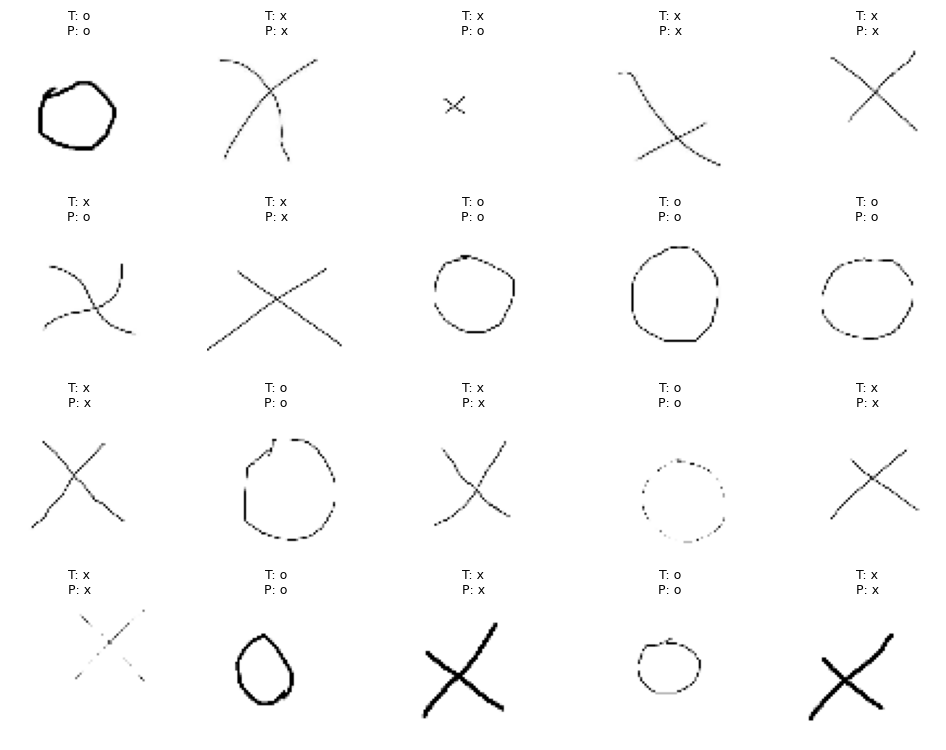

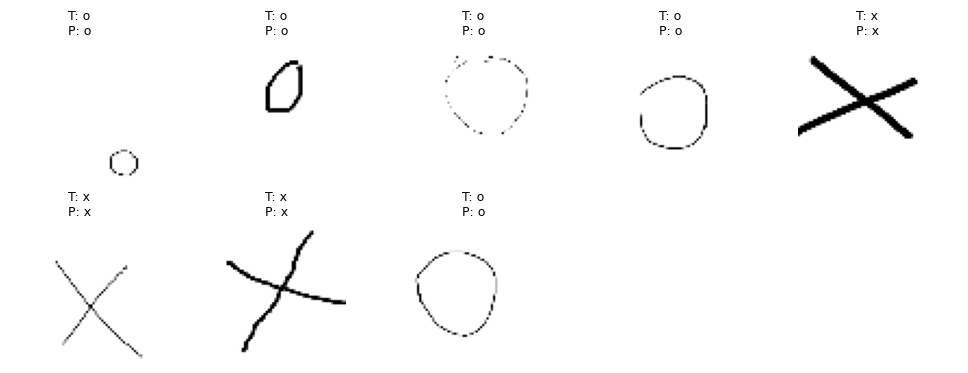

In [7]:
# 시각화 함수 (20개씩 나눠서 출력)
def visualize_predictions(images, true_labels, predicted_labels, batch_size=20):
    total = len(images)
    for start in range(0, total, batch_size):
        end = min(start + batch_size, total)
        batch_images = images[start:end]
        batch_true = true_labels[start:end]
        batch_pred = predicted_labels[start:end]

        num_images = len(batch_images)
        num_cols = 5
        num_rows = (num_images + num_cols - 1) // num_cols
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
        axes = axes.flatten()

        for i in range(num_rows * num_cols):
            ax = axes[i]
            if i < num_images:
                image = batch_images[i].squeeze()
                true = batch_true[i]
                pred = batch_pred[i]
                ax.imshow(image, cmap='gray')
                ax.set_title(f"T: {true}\nP: {pred}", fontsize=9)
                ax.axis('off')
            else:
                ax.axis('off')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

#  시각화 실행
visualize_predictions(test_images, true_labels_str, pred_labels_str)

In [8]:
import cv2

In [9]:
oldx = oldy = -1  # 좌표 기본값
drawing = False

# 버튼 영역 좌표
BUTTON_HEIGHT = 50
CLEAR_BTN = (0, 480, 150, 530)   # (x1, y1, x2, y2)
PREDICT_BTN = (150, 480, 300, 530)

def on_mouse(event, x, y, flags, param):
    global oldx, oldy, drawing, img

    if event == cv2.EVENT_LBUTTONDOWN:
        # 버튼 클릭 여부 확인
        if CLEAR_BTN[0] <= x <= CLEAR_BTN[2] and CLEAR_BTN[1] <= y <= CLEAR_BTN[3]:
            clear_canvas()
            return
        if PREDICT_BTN[0] <= x <= PREDICT_BTN[2] and PREDICT_BTN[1] <= y <= PREDICT_BTN[3]:
            result = classify_drawing(img_canvas)
            print("판단 결과:", result)
            return

        # 그림 시작
        drawing = True
        oldx, oldy = x, y

    elif event == cv2.EVENT_MOUSEMOVE and drawing:
        if y < 480:  # 버튼 영역 제외
            cv2.line(img_canvas, (oldx, oldy), (x, y), (0, 0, 255), 4, cv2.LINE_AA)
            oldx, oldy = x, y

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False

def clear_canvas():
    global img_canvas
    img_canvas = np.ones((480, 640, 3), dtype=np.uint8) * 255

def classify_drawing(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return "그림 없음"

    has_hole = False
    if hierarchy is not None:
        for i in range(len(hierarchy[0])):
            if hierarchy[0][i][3] != -1:  # 부모 윤곽선이 있으면 구멍
                has_hole = True
                break

    return "O" if has_hole else "X"

def draw_buttons(frame):
    # 초기화 버튼
    cv2.rectangle(frame, (CLEAR_BTN[0], CLEAR_BTN[1]), (CLEAR_BTN[2], CLEAR_BTN[3]), (200, 200, 200), -1)
    cv2.putText(frame, "Clear", (20, 510), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

    # 예측 버튼
    cv2.rectangle(frame, (PREDICT_BTN[0], PREDICT_BTN[1]), (PREDICT_BTN[2], PREDICT_BTN[3]), (200, 200, 200), -1)
    cv2.putText(frame, "Predict", (170, 510), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

# 초기 캔버스 생성
clear_canvas()

cv2.namedWindow('Draw O/X')
cv2.setMouseCallback('Draw O/X', on_mouse)

while True:
    # 버튼 포함 전체 화면
    display_frame = np.vstack([
        img_canvas,
        np.ones((50, 640, 3), dtype=np.uint8) * 255
    ])

    draw_buttons(display_frame)

    cv2.imshow('Draw O/X', display_frame)
    key = cv2.waitKey(1) & 0xFF

    if key == 27:  # ESC 종료
        break

cv2.destroyAllWindows()


판단 결과: O
판단 결과: X
판단 결과: O
판단 결과: O
판단 결과: X
판단 결과: X
판단 결과: O
